#### R包的导入及数据的获取与预处理

In [159]:
options(warn=-1)

In [160]:
library(lubridate)
library(xts)
library(quantmod)
library(Tushare)
library(TSA)
library(fUnitRoots)
library(urca)
library(fBasics)
library(forecast)
library(FinTS)
library(fGarch)
library(rugarch)




In [161]:
api<-pro_api(token="731ee2eafa47ae6b8c98993e8b30001b51bd3085cd69d63870e745c9")
xcdl<-api(api_name ='daily',ts_code ='600505.SH',start_date='20170101',end_date='20220101')
time<-as.Date(ymd(xcdl$trade_date))
xcdl_close_price<-xts(xcdl$close,order.by=time)
xcdl_logreturn<-dailyReturn(xcdl_close_price,type='log')[-1]
time=index(xcdl_logreturn)

# 运用选取的股票进行收益率及其波动特征分析与建模

## 分析股票对数收益率序列的基本统计特征以及其序列相关性与独立性

### 对数收益率序列基本统计特征

In [162]:
basicStats(xcdl_logreturn)

,daily.returns
,<dbl>
nobs,1216.000000
NAs,0.000000
Minimum,-0.105956
Maximum,0.095955
1. Quartile,-0.013784
3. Quartile,0.012414
Mean,0.000013
Median,0.000000
Sum,0.015341


#### 收益率序列基本统计特征如表所示

### 相关性与独立性检验

In [163]:
Box.test(xcdl_logreturn)


	Box-Pierce test

data:  xcdl_logreturn
X-squared = 2.5134, df = 1, p-value = 0.1129


#### Box检验显示接受原假设，即认为对数收益率序列不存在自相关

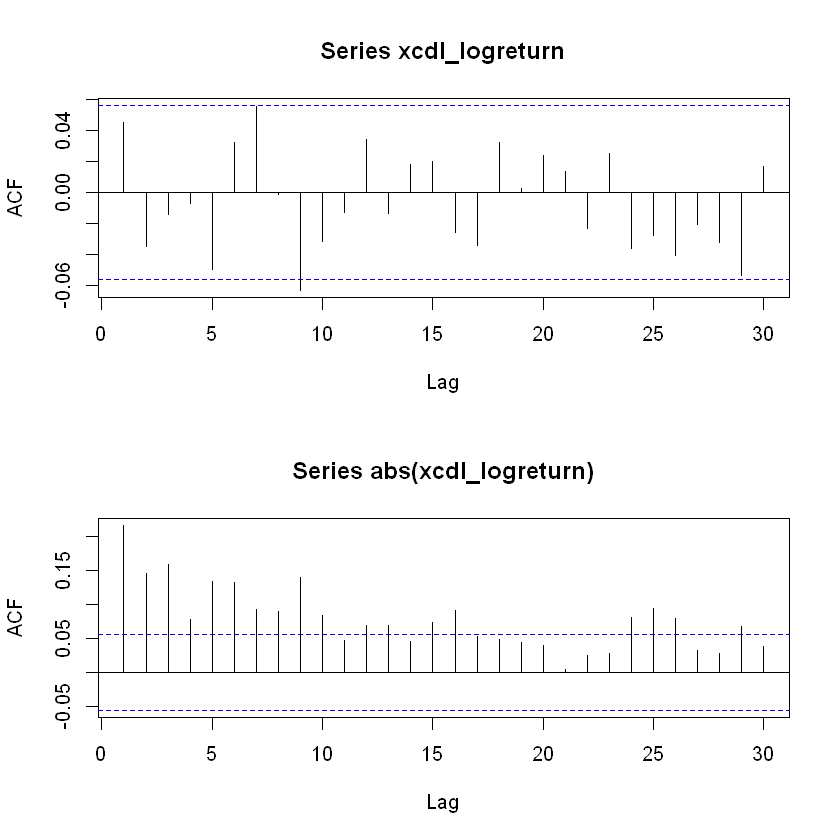

In [164]:
par(mfrow=c(2,1))
acf(xcdl_logreturn)
acf(abs(xcdl_logreturn))

#### 对数收益率仅在9阶之后有一个超过两倍标准差的相关，其绝对值序列有多个值在界限之外，表明收益率序列不存在独立性

## 选择合适的线性模型刻画收益率序列作为波动率模型中的均值方程，描述其残差序列的基本特征并运用多种方法进行 ARCH 效应的检验

### 建立均值方差

#### 由于收益率序列不具有自相关性，采取方法一建立均值方程

In [165]:
xcdl_mean<-xcdl_logreturn-mean(xcdl_logreturn)

### 残差的基本特征

In [166]:
basicStats(xcdl_mean)

,daily.returns
,<dbl>
nobs,1216.000000
NAs,0.000000
Minimum,-0.105969
Maximum,0.095942
1. Quartile,-0.013796
3. Quartile,0.012402
Mean,0.000000
Median,-0.000013
Sum,0.000000


###  ARCH 效应检验

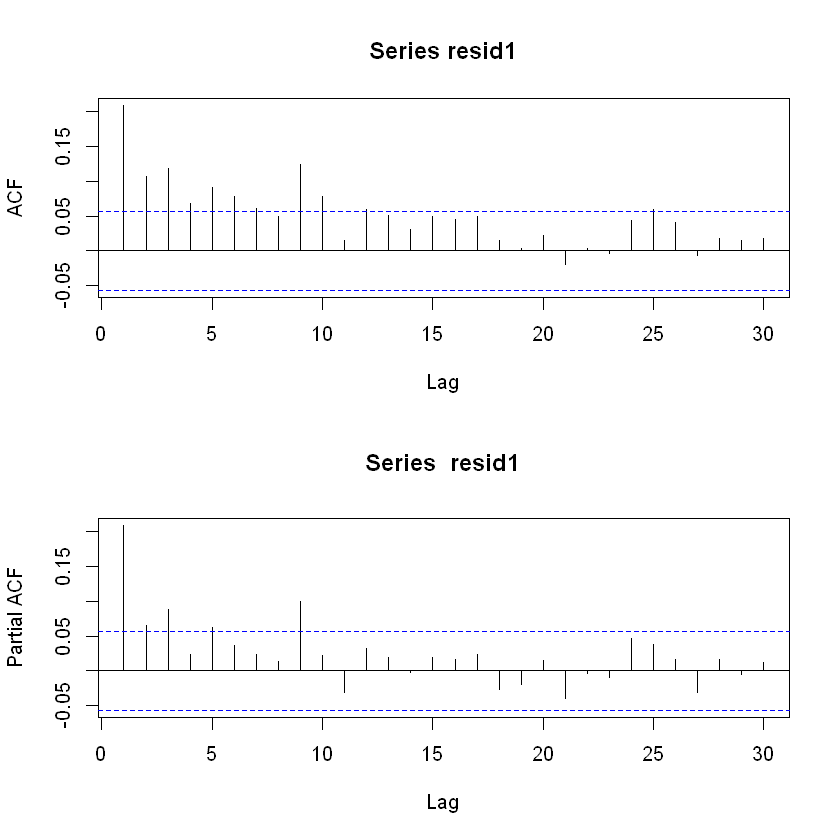

In [167]:
par(mfrow=c(2,1))
resid1=xcdl_mean^2
acf(resid1)
pacf(resid1)

#### 从残差平方序列自相关图与偏自相关图来看，残差序列在滞后多阶之后依然超过界限值，序列不平稳，存在ARCH效应

In [168]:
Box.test(resid1)


	Box-Pierce test

data:  resid1
X-squared = 52.622, df = 1, p-value = 4.042e-13


#### BOX检验p值为4.04*10^-14，拒绝原假设，即残差序列存在自相关，存在ARCH效应

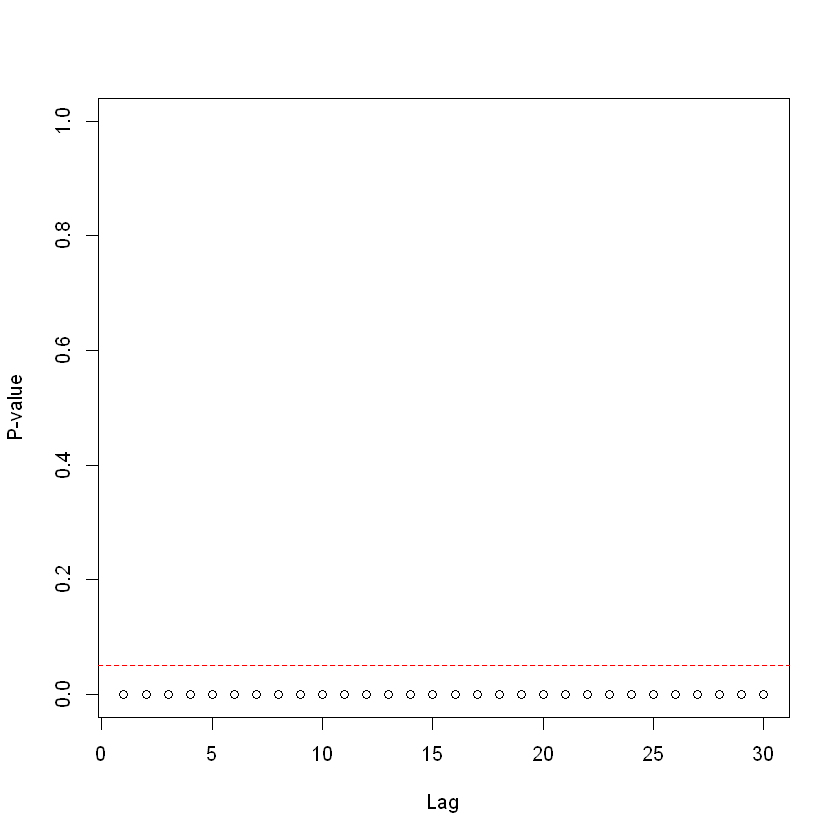

In [169]:
McLeod.Li.test(y=resid1)

#### McLeod.Li检验结果显示，西昌电力的股价存在ARCH效应

In [170]:
ArchTest(resid1,lag=12)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  resid1
Chi-squared = 51.854, df = 12, p-value = 6.581e-07


#### p值显著趋于0，拒绝原假设，即西昌电力股价具有arch效应

## 选取合适滞后阶数的 GARCH 模型对股票对数收益率进行波动率建模，检验模型结果并解读模型结果的基本含义

### GARCH模型建模

In [171]:
xcdl_garch<-garchFit(~1+garch(1,1),data=xcdl_logreturn,trace = F)
summary(xcdl_garch)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + garch(1, 1), data = xcdl_logreturn, trace = F) 

Mean and Variance Equation:
 data ~ 1 + garch(1, 1)
<environment: 0x000001dfcfad8988>
 [data = xcdl_logreturn]

Conditional Distribution:
 norm 

Coefficient(s):
         mu        omega       alpha1        beta1  
-2.9390e-05   5.4681e-05   1.1268e-01   8.1816e-01  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu     -2.939e-05   7.028e-04   -0.042  0.96664    
omega   5.468e-05   1.678e-05    3.259  0.00112 ** 
alpha1  1.127e-01   2.322e-02    4.853 1.21e-06 ***
beta1   8.182e-01   3.880e-02   21.089  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2721.754    normalized:  2.238284 

Description:
 Fri Apr 28 16:01:36 2023 by user: 20392 


Standardised Residuals Tests:
                                Statistic p-Value  
 Jarque-Bera Test   R    Chi^2  639.5166  0        
 Sh

### 模型结果检验

In [172]:
vo_garch<-volatility(xcdl_garch)
vo_garch<-xts(vo_garch,order.by = time)

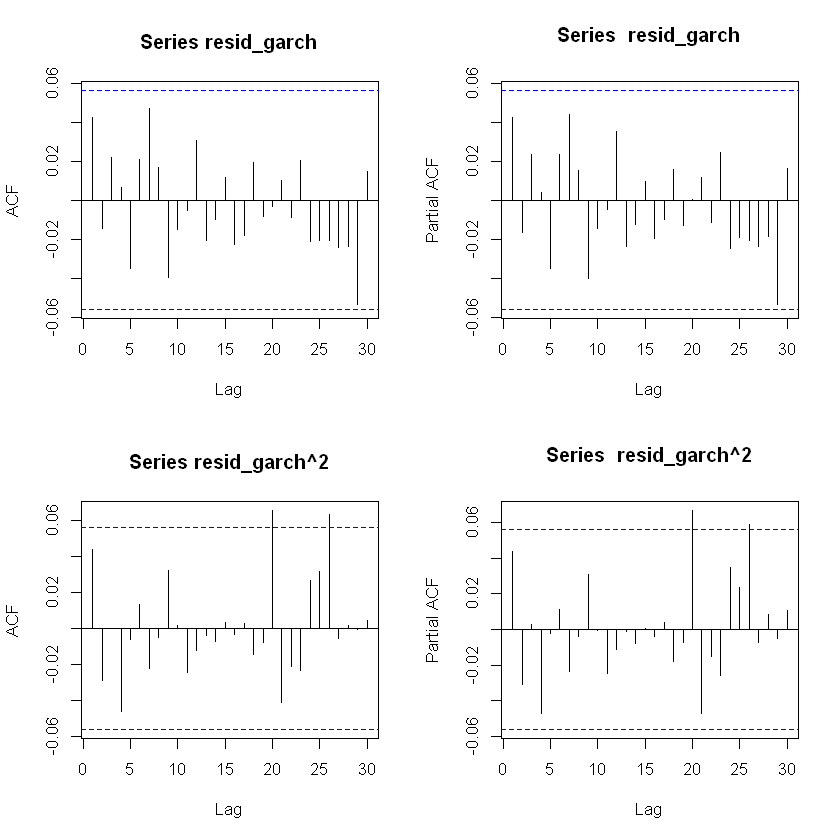

In [173]:
par(mfrow=c(2,2))
resid_garch<-residuals(xcdl_garch,standardize=T)
resid_garch<-xts(resid_garch,order.by = time)
acf(resid_garch)
pacf(resid_garch)
acf(resid_garch^2)
pacf(resid_garch^2)

### 模型结果解读

- 模型如下：
$$
r_{t}=-2.9390*10^{-5}+α_{t},  \quad α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim N(0,1)
$$

$$
σ_{t}^2=5.468*10^{-5}+0.11268α_{t-1}^{2} +0.81816σ_{t-1}^{2}
$$

- 模型参数p值均拒绝原假设，所估计的参数在统计意义上显著
- aic为-4.469990
- 标准化残差序列接受原假设，是白噪声序列，同时标准化残差序列的平方也能通过Ljung-Box检验，接受ARCH效应的原假设，拟合模型很好的刻画了收益率的均值和方差
- $σ^2$对过去的依赖主要来源于β$_1$=0.81816

#### 从标准化残差序列和其平方的ACF和PACF图来看，其残差序列是平稳的，平方序列只有几个值超过界限，即仅存在轻微的自相关性，模型拟合充分

## 讨论不同新息分布假设对 GARCH 模型构建结果的影响，并在对残差（及其平方）序列特征讨论后对该股票对数收益率波动区间加以预测，评估各类分布假设下预测结果的差异

### 有偏正态分布

In [174]:
xcdl_garch_1<-garchFit(~1+garch(1,1),data=xcdl_logreturn,trace = F,cond.dist = "snorm")
summary(xcdl_garch_1)
resid_garch_1<-residuals(xcdl_garch_1,standardize=T)
resid_garch_1<-xts(resid_garch_1,order.by = time)
vo_garch_1<-volatility(xcdl_garch_1)
vo_garch_1<-xts(vo_garch_1,order.by = time)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + garch(1, 1), data = xcdl_logreturn, cond.dist = "snorm", 
    trace = F) 

Mean and Variance Equation:
 data ~ 1 + garch(1, 1)
<environment: 0x000001dfc83fbf20>
 [data = xcdl_logreturn]

Conditional Distribution:
 snorm 

Coefficient(s):
        mu       omega      alpha1       beta1        skew  
1.2616e-04  5.8497e-05  1.1722e-01  8.0827e-01  1.0573e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     1.262e-04   7.228e-04    0.175 0.861437    
omega  5.850e-05   1.753e-05    3.337 0.000848 ***
alpha1 1.172e-01   2.420e-02    4.844 1.27e-06 ***
beta1  8.083e-01   4.027e-02   20.071  < 2e-16 ***
skew   1.057e+00   3.163e-02   33.430  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2723.572    normalized:  2.23978 

Description:
 Fri Apr 28 16:01:36 2023 by user: 20392 


Standardised Residuals Tests:
                   

### 标准t分布

In [175]:
xcdl_garch_2<-garchFit(~1+garch(1,1),data=xcdl_logreturn,trace = F,cond.dist = "std")
summary(xcdl_garch_2)
resid_garch_2<-residuals(xcdl_garch_2,standardize=T)
resid_garch_2<-xts(resid_garch_2,order.by = time)
vo_garch_2<-volatility(xcdl_garch_2)
vo_garch_2<-xts(vo_garch_2,order.by = time)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + garch(1, 1), data = xcdl_logreturn, cond.dist = "std", 
    trace = F) 

Mean and Variance Equation:
 data ~ 1 + garch(1, 1)
<environment: 0x000001dfc98eb0a0>
 [data = xcdl_logreturn]

Conditional Distribution:
 std 

Coefficient(s):
         mu        omega       alpha1        beta1        shape  
-1.2616e-04   4.5916e-05   1.7070e-01   8.0547e-01   3.5457e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu     -1.262e-04   5.568e-04   -0.227 0.820741    
omega   4.592e-05   1.909e-05    2.405 0.016171 *  
alpha1  1.707e-01   4.445e-02    3.840 0.000123 ***
beta1   8.055e-01   4.745e-02   16.973  < 2e-16 ***
shape   3.546e+00   3.883e-01    9.132  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2812.647    normalized:  2.313032 

Description:
 Fri Apr 28 16:01:36 2023 by user: 20392 


Standardised Residuals Tests:
      

### 有偏T分布

In [176]:
xcdl_garch_3<-garchFit(~1+garch(1,1),data=xcdl_logreturn,trace = F,cond.dist = "sstd")
summary(xcdl_garch_3)
resid_garch_3<-residuals(xcdl_garch_3,standardize=T)
resid_garch_3<-xts(resid_garch_3,order.by = time)
vo_garch_3<-volatility(xcdl_garch_3)
vo_garch_3<-xts(vo_garch_3,order.by = time)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + garch(1, 1), data = xcdl_logreturn, cond.dist = "sstd", 
    trace = F) 

Mean and Variance Equation:
 data ~ 1 + garch(1, 1)
<environment: 0x000001dfd339ba40>
 [data = xcdl_logreturn]

Conditional Distribution:
 sstd 

Coefficient(s):
         mu        omega       alpha1        beta1         skew        shape  
-1.2616e-04   4.7366e-05   1.7195e-01   8.0210e-01   1.0541e+00   3.5572e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu     -1.262e-04   6.668e-04   -0.189 0.849941    
omega   4.737e-05   1.947e-05    2.433 0.014989 *  
alpha1  1.720e-01   4.448e-02    3.866 0.000111 ***
beta1   8.021e-01   4.773e-02   16.806  < 2e-16 ***
skew    1.054e+00   4.180e-02   25.218  < 2e-16 ***
shape   3.557e+00   3.903e-01    9.113  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2813.919    normalized:  2.314078 

Description:


### 广义误差分布

In [177]:
xcdl_garch_4<-garchFit(~1+garch(1,1),data=xcdl_logreturn,trace = F,cond.dist = "ged")
summary(xcdl_garch_4)
resid_garch_4<-residuals(xcdl_garch_4,standardize=T)
resid_garch_4<-xts(resid_garch_4,order.by = time)
vo_garch_4<-volatility(xcdl_garch_4)
vo_garch_4<-xts(vo_garch_4,order.by = time)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + garch(1, 1), data = xcdl_logreturn, cond.dist = "ged", 
    trace = F) 

Mean and Variance Equation:
 data ~ 1 + garch(1, 1)
<environment: 0x000001dfd20387c0>
 [data = xcdl_logreturn]

Conditional Distribution:
 ged 

Coefficient(s):
         mu        omega       alpha1        beta1        shape  
-8.8172e-07   4.4233e-05   1.3491e-01   8.1307e-01   1.0867e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu     -8.817e-07   1.428e-04   -0.006   0.9951    
omega   4.423e-05   1.808e-05    2.447   0.0144 *  
alpha1  1.349e-01   3.454e-02    3.906 9.38e-05 ***
beta1   8.131e-01   4.836e-02   16.814  < 2e-16 ***
shape   1.087e+00   5.441e-02   19.973  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2803.874    normalized:  2.305817 

Description:
 Fri Apr 28 16:01:37 2023 by user: 20392 


Standardised Residuals Tests:
      

### 有偏广义误差分布

In [178]:
xcdl_garch_5<-garchFit(~1+garch(1,1),data=xcdl_logreturn,trace = F,cond.dist = "sged")
summary(xcdl_garch_5)
resid_garch_5<-residuals(xcdl_garch_5,standardize=T)
resid_garch_5<-xts(resid_garch_5,order.by = time)
vo_garch_5<-volatility(xcdl_garch_5)
vo_garch_5<-xts(vo_garch_5,order.by = time)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + garch(1, 1), data = xcdl_logreturn, cond.dist = "sged", 
    trace = F) 

Mean and Variance Equation:
 data ~ 1 + garch(1, 1)
<environment: 0x000001dfc7739930>
 [data = xcdl_logreturn]

Conditional Distribution:
 sged 

Coefficient(s):
        mu       omega      alpha1       beta1        skew       shape  
1.0767e-04  4.4658e-05  1.3572e-01  8.1165e-01  1.0043e+00  1.0881e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
        Estimate  Std. Error  t value Pr(>|t|)    
mu     1.077e-04   6.713e-04    0.160   0.8726    
omega  4.466e-05   1.824e-05    2.448   0.0144 *  
alpha1 1.357e-01   3.485e-02    3.895 9.83e-05 ***
beta1  8.117e-01   4.888e-02   16.604  < 2e-16 ***
skew   1.004e+00   2.309e-02   43.489  < 2e-16 ***
shape  1.088e+00   5.467e-02   19.904  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2803.889    normalized:  2.305829 

Description:
 Fri Apr 28 16:01:3

### 对模型构建结果的影响分析——在六种不同新息分布的情况下

- 不同新息分布下模型结果
    - 标准正态分布
    $$
r_{t}=-2.9390*10^{-5}+α_{t}, \quad  α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim N(0,1)
$$
$$
σ_{t}^2=5.468*10^{-5}+0.11268α_{t-1}^{2} +0.81816σ_{t-1}^{2}
$$
    - 有偏正态分布
        $$
r_{t}=1.2616*10^{-4}+α_{t}, \quad  α_{t}=σ_{t}ξ_{t}
$$
$$
σ_{t}^2=5.8497*10^{-5}+0.11722α_{t-1}^{2} +0.80827σ_{t-1}^{2}
$$
    - 标准t分布
    $$
r_{t}=-1.2616*10^{-4}+α_{t},  \quad α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim t^{*}(3.5457)
$$
$$
σ_{t}^2=4.5916*10^{-5}+0.17070α_{t-1}^{2} +0.80547σ_{t-1}^{2}
$$
    - 有偏t分布
    $$
r_{t}=-1.2616*10^{-4}+α_{t},  \quad α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim t^{*}_{1.0541,3.5572}
$$
$$
σ_{t}^2=4.7366*10^{-5}+0.17195α_{t-1}^{2} +0.80210σ_{t-1}^{2}
$$
    - 广义误差分布
    $$
r_{t}=-8.8172*10^{-7}+α_{t}, \quad  α_{t}=σ_{t}ξ_{t}
$$
$$
σ_{t}^2=4.4233*10^{-5}+0.13491α_{t-1}^{2} +0.81307σ_{t-1}^{2}
$$
    - 有偏广义误差分布
    $$
r_{t}=-1.0767*10^{-4}+α_{t}, \quad  α_{t}=σ_{t}ξ_{t}
$$
$$
σ_{t}^2=4.4658*10^{-5}+0.13572α_{t-1}^{2} +0.81165σ_{t-1}^{2}
$$


- 在不同的新息分布条件下，对各参数估计结果差异并没有很大，除了广义误差分布的mu与其他分布情况下存在数量级上的差异外，其他参数估计结果都比较接近，都在一个较为合理的区间

- 在不同的新息分布情况下，参数至少在0.05的水平上显著，且残差及残差平方序列的白噪声检验均能通过，表示模型拟合效果都较好。

In [179]:
aic=c(-4.69990,-4.471336,-4.617840,-4.618287,-4.603411,-4.601790)
col_name<-c("标准正态分布","有偏正态分布","标准t分布","有偏t分布","广义误差分布","有偏广义误差分布")
name_aic<-setNames(aic,col_name)
data.frame(name_aic)

,name_aic
,<dbl>
标准正态分布,-4.699900
有偏正态分布,-4.471336
标准t分布,-4.617840
有偏t分布,-4.618287
广义误差分布,-4.603411
有偏广义误差分布,-4.601790


- 对比各个模型的AIC值，在有偏t分布的情况下，模型的AIC值最小。

- 残差ACF与PACF对比

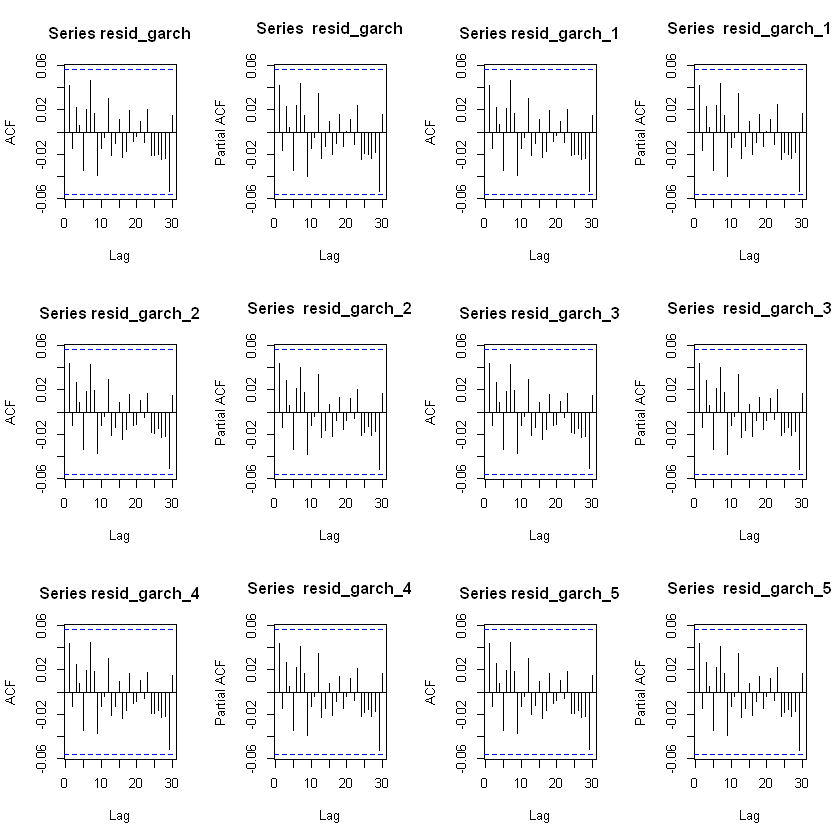

In [180]:
par(mfrow=c(3,4))
acf(resid_garch)
pacf(resid_garch)
acf(resid_garch_1)
pacf(resid_garch_1)
acf(resid_garch_2)
pacf(resid_garch_2)
acf(resid_garch_3)
pacf(resid_garch_3)
acf(resid_garch_4)
pacf(resid_garch_4)
acf(resid_garch_5)
pacf(resid_garch_5)

- 残差平方ACF与PACF对比

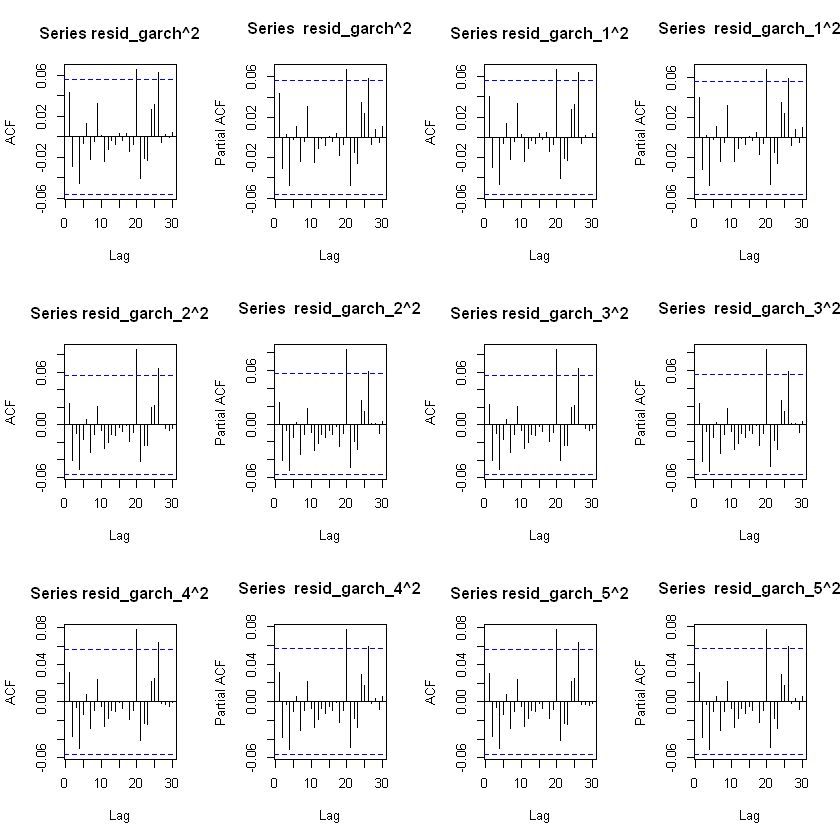

In [181]:
par(mfrow=c(3,4))
acf(resid_garch^2)
pacf(resid_garch^2)
acf(resid_garch_1^2)
pacf(resid_garch_1^2)
acf(resid_garch_2^2)
pacf(resid_garch_2^2)
acf(resid_garch_3^2)
pacf(resid_garch_3^2)
acf(resid_garch_4^2)
pacf(resid_garch_4^2)
acf(resid_garch_5^2)
pacf(resid_garch_5^2)

#### 可以看到，在各种新息分布的情况下，残差序列的ACF图与PACF图均在界限之内，其平方序列大约都在滞后多阶滞后才会超过界限值，可以认为残差序列及其平方序列没有序列相关性

### 各种新息分布情况下预测比较

#### 预测图比较

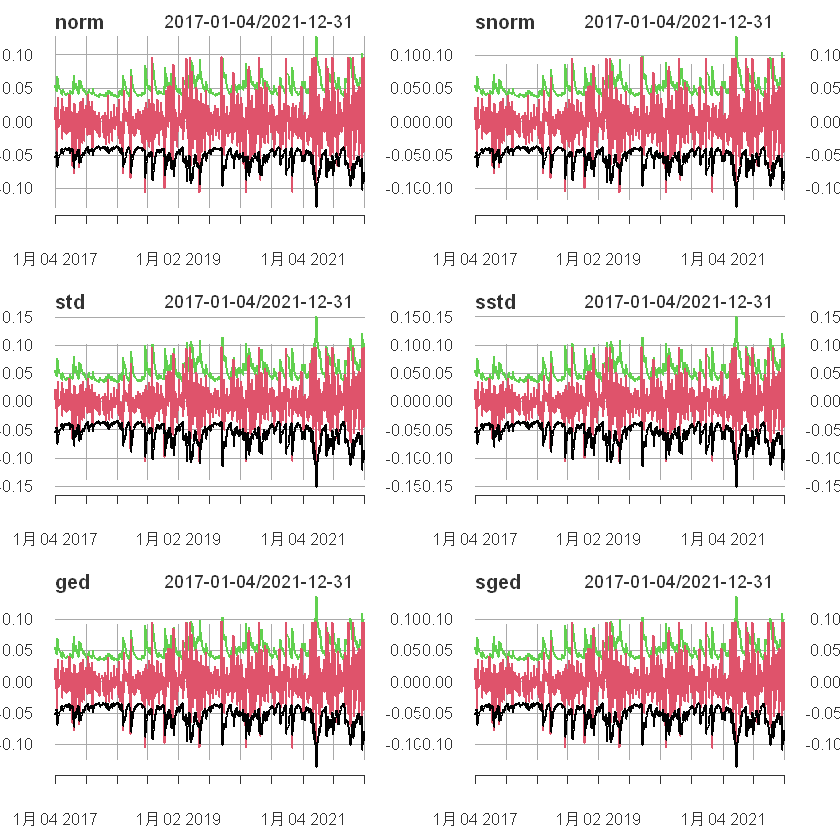

In [182]:
par(mfrow=c(3,2))
mu<-coef(xcdl_garch)["mu"]
lb=mu-2*vo_garch
ub=mu+2*vo_garch
dat<-cbind(lb,xcdl_logreturn,ub)
ylim=range(c(lb,xcdl_logreturn,ub))
plot(dat,main="norm")
mu_1<-coef(xcdl_garch_1)["mu"]
lb_1=mu_1-2*vo_garch_1
ub_1=mu_1+2*vo_garch_1
dat_1<-cbind(lb_1,xcdl_logreturn,ub_1)
ylim=range(c(lb_1,xcdl_logreturn,ub_1))
plot(dat_1,main="snorm")
mu_2<-coef(xcdl_garch_2)["mu"]
lb_2=mu_2-2*vo_garch_2
ub_2=mu_2+2*vo_garch_2
dat_2<-cbind(lb_2,xcdl_logreturn,ub_2)
ylim=range(c(lb_2,xcdl_logreturn,ub_2))
plot(dat_2,main="std")
mu_3<-coef(xcdl_garch_3)["mu"]
lb_3=mu_3-2*vo_garch_3
ub_3=mu_3+2*vo_garch_3
dat_3<-cbind(lb_3,xcdl_logreturn,ub_3)
ylim=range(c(lb_3,xcdl_logreturn,ub_3))
plot(dat_3,main="sstd")
mu_4<-coef(xcdl_garch_4)["mu"]
lb_4=mu_4-2*vo_garch_4
ub_4=mu_4+2*vo_garch_4
dat_4<-cbind(lb_4,xcdl_logreturn,ub_4)
ylim=range(c(lb_4,xcdl_logreturn,ub_4))
plot(dat_4,main="ged")
mu_5<-coef(xcdl_garch_5)["mu"]
lb_5=mu_5-2*vo_garch_5
ub_5=mu_5+2*vo_garch_5
dat_5<-cbind(lb_5,xcdl_logreturn,ub_5)
ylim=range(c(lb_5,xcdl_logreturn,ub_5))
plot(dat_5,main="sged")

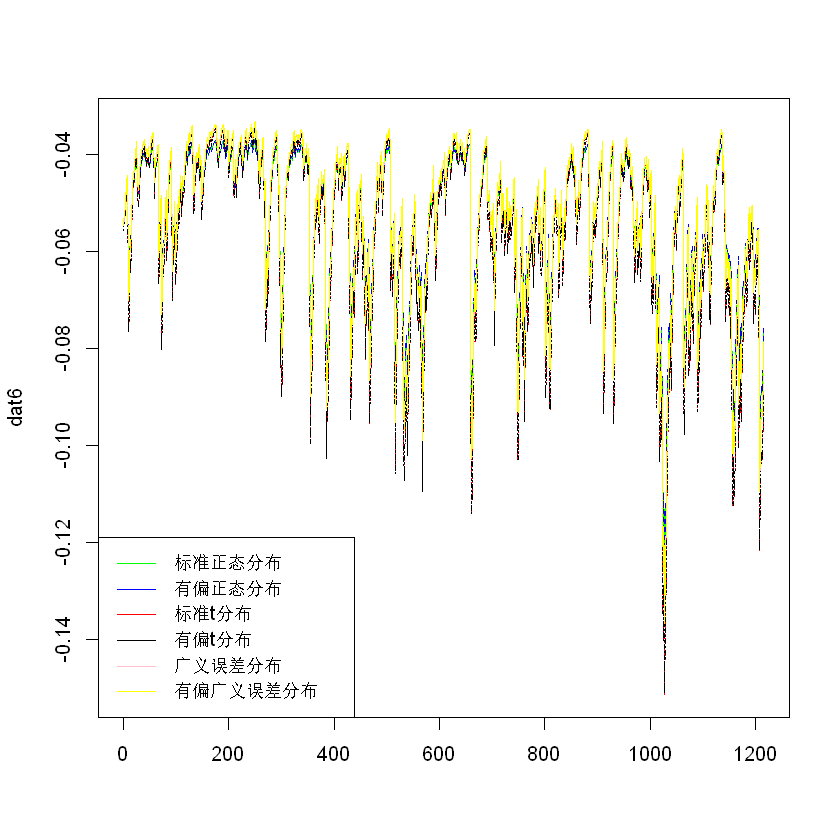

In [183]:
dat6<-cbind(lb,lb_1,lb_2,lb_3,lb_4,lb_5)
colnames(dat6)=col_name
matplot(dat6,col=c("green", "blue", "red","black","pink","yellow"),type="l")
legend( "bottomleft",lty=1, col=c("green", "blue", "red","black","pink","yellow"),legend=col_name)

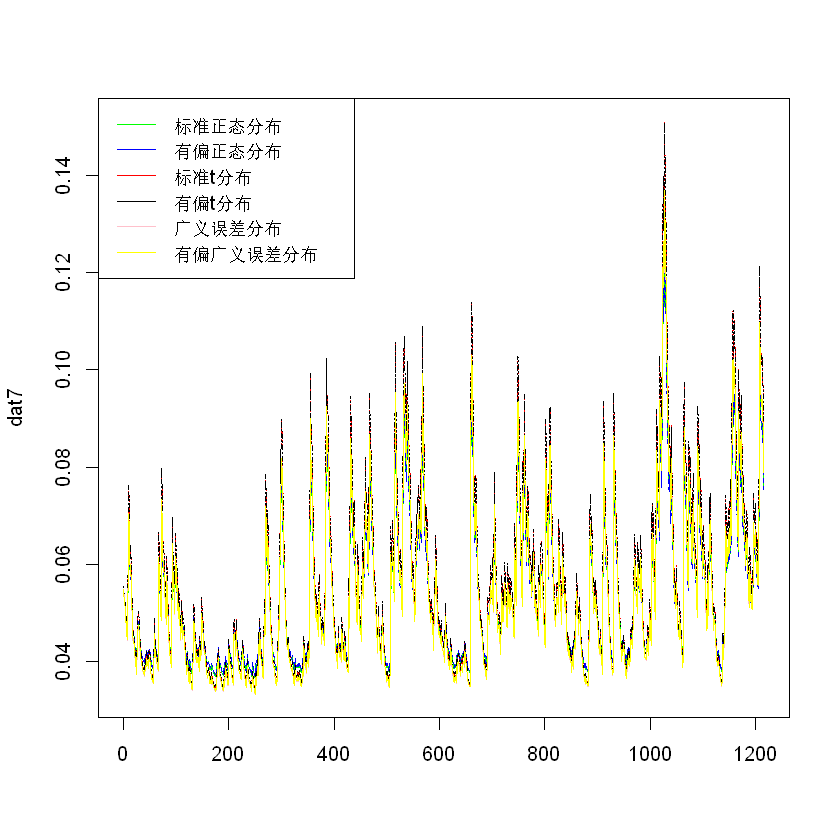

In [184]:
dat7<-cbind(ub,ub_1,ub_2,ub_3,ub_4,ub_5)
colnames(dat7)=col_name
matplot(dat7,col=c("green", "blue", "red","black","pink","yellow"),type="l")
legend( "topleft",lty=1, col=c("green", "blue", "red","black","pink","yellow"),legend=col_name)

#### 比较前5步差异

In [185]:
head(dat6,5)

           标准正态分布 有偏正态分布   标准t分布   有偏t分布 广义误差分布
2017-01-04  -0.05462922  -0.05446847 -0.05563015 -0.05562556  -0.05468374
2017-01-05  -0.05226282  -0.05197652 -0.05279139 -0.05275144  -0.05188810
2017-01-06  -0.05164269  -0.05131910 -0.05250269 -0.05245922  -0.05118976
2017-01-09  -0.04901783  -0.04860365 -0.04907540 -0.04900299  -0.04805613
2017-01-10  -0.04905322  -0.04866045 -0.04963921 -0.04958368  -0.04815322
           有偏广义误差分布
2017-01-04      -0.05457463
2017-01-05      -0.05174535
2017-01-06      -0.05102241
2017-01-09      -0.04787364
2017-01-10      -0.04795792

In [186]:
head(dat7,5)

           标准正态分布 有偏正态分布  标准t分布  有偏t分布 广义误差分布
2017-01-04   0.05457044   0.05472079 0.05537783 0.05537325   0.05468198
2017-01-05   0.05220404   0.05222884 0.05253908 0.05249912   0.05188634
2017-01-06   0.05158391   0.05157141 0.05225037 0.05220691   0.05118800
2017-01-09   0.04895905   0.04885596 0.04882309 0.04875067   0.04805436
2017-01-10   0.04899444   0.04891276 0.04938689 0.04933137   0.04815145
           有偏广义误差分布
2017-01-04       0.05478997
2017-01-05       0.05196069
2017-01-06       0.05123775
2017-01-09       0.04808898
2017-01-10       0.04817326

#### 在各种新息分布情况下，对于波动率的预测的上下限并没有很大的差异，无论是从前5步预测结果来看，还是通过六种分布的波动率上下限图来看，都没有较大的差异

## 分别运用 IGARCH 模型和 GARCH-M 模型刻画股票对数收益率的波动特征，检验模型结果并分别解读模型结果的基本含义

### IGARCH模型建模

In [187]:
par(mfrow=c(1,1))
igarch_str<-ugarchspec(variance.model =list(model= "iGARCH" ,garchOrder =c(1,1), variance.targeting =T), mean.model = list(armaOrder =c(0,0),include.mean =T), distribution.model ="sstd")
igarch_xcdl<-ugarchfit(igarch_str,data=xcdl_logreturn,solver ="gosolnp")
show(igarch_xcdl)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: iGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.000803    0.000613  -1.3096 0.190333
alpha1  0.046025    0.010902   4.2219 0.000024
beta1   0.953975          NA       NA       NA
skew    1.009900    0.036474  27.6879 0.000000
shape   4.112462    0.299992  13.7086 0.000000
omega   0.000003          NA       NA       NA

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     -0.000803    0.000651  -1.2335 0.217375
alpha1  0.046025    0.016799   2.7398 0.006147
beta1   0.953975          NA       NA       NA
skew    1.009900    0.037793  26.7216 0.000000
shape   4.112462    0.298734  13.7663 0.000000
omega   0.000003          NA       NA       NA

LogLike


please wait...calculating quantiles...


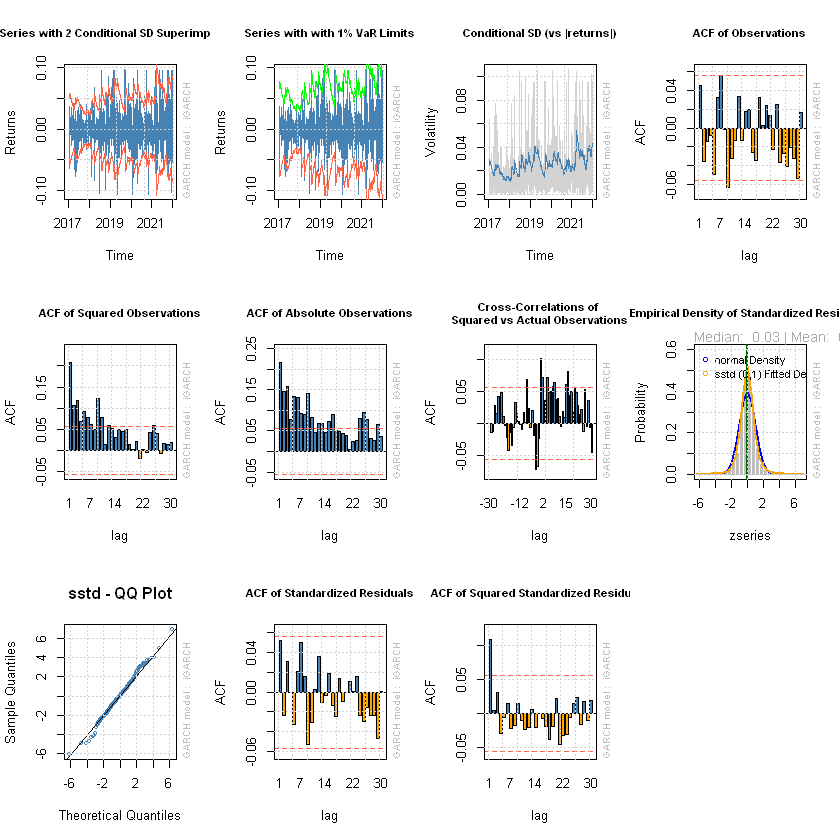

In [188]:
par(mfrow=c(3,4))
for (i in 1:12){
plot(igarch_xcdl,which=i)}

#### 模型如下：
- 有偏t分布
    $$
r_{t}=-0.000803+α_{t}, \quad  α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim t^{*}_{1.009899,4.1124392}
$$
$$
σ_{t}^2=0.000003+0.046025α_{t-1}^{2} +0.953975σ_{t-1}^{2}
$$

- 标准化残差序列能在5%置信水平下通过检验，不存在序列相关，但其平方序列均未能在1%的置信水平下通过Ljung-Box检验，表明其存在序列相关
- aic值为-4.6019，不如前述各种有偏t分布Garch（1，1）模型
- 残余ARCH效应检验通过，不存在ARCH效应
- 参数稳定性检验不通过
- 残差分布符合假设
- 模型拟合不充分



### GARCH-M模型建模

In [189]:
garchm_str<-ugarchspec(variance.model =list(model= "sGARCH" ,garchOrder =c(1,1), variance.targeting =F), mean.model = list(armaOrder =c(0,0),include.mean =T,archm=T,archpow=2), distribution.model ="sstd")
garchm_xcdl<-ugarchfit(garchm_str,data=xcdl_logreturn,solver ="gosolnp")
garchm_xcdl


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000922    0.001129  0.81662 0.414144
archm  -1.862237    1.512387 -1.23132 0.218202
omega   0.000051    0.000021  2.44121 0.014638
alpha1  0.174699    0.044739  3.90489 0.000094
beta1   0.795493    0.048871 16.27733 0.000000
skew    1.045417    0.041893 24.95456 0.000000
shape   3.536939    0.387324  9.13174 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000922    0.001178  0.78286 0.433709
archm  -1.862237    1.330963 -1.39916 0.161764
omega   0.000051    0.000026  1.95871 0.050146
alpha1  0.174699    0.048143  3.62872 0.000285
beta1   0.795493    0.061021 13.03647 0.000000
skew    


please wait...calculating quantiles...


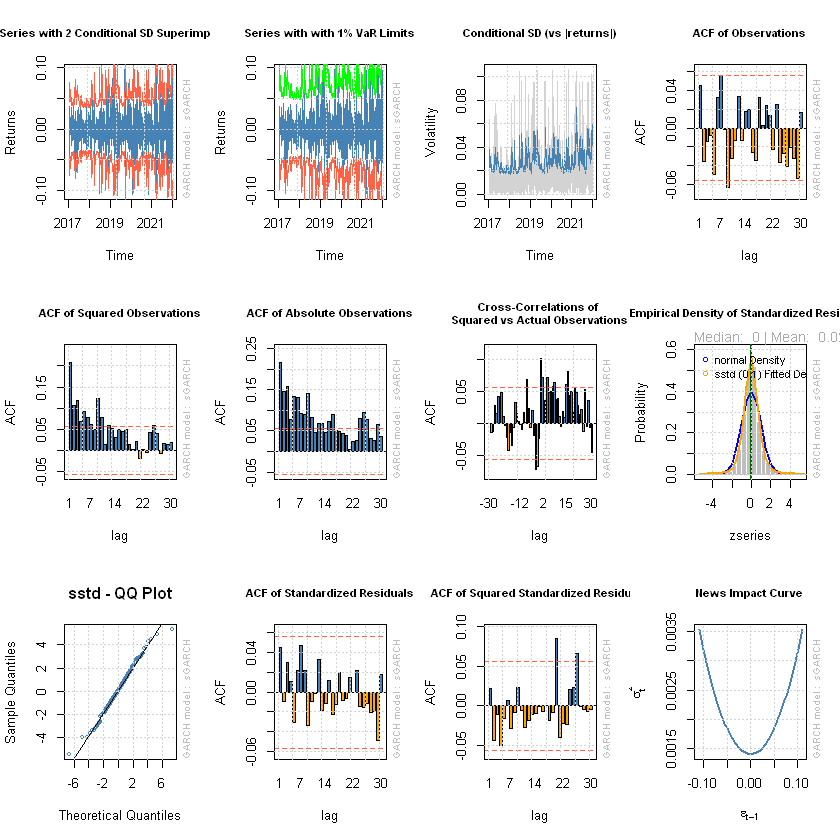

In [190]:
par(mfrow=c(3,4))
for (i in 1:12){
plot(garchm_xcdl,which=i)}

#### 模型如下：
- 有偏t分布
    $$
μ_{t}=-0.000922-1.862698σ_{t}^{2}+α_{t}, \quad  α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim t^{*}_{1.045446,3.537221}
$$
$$
σ_{t}^2=0.000051+0.174669α_{t-1}^{2} +0.795525σ_{t-1}^{2}
$$
- 其中archm=-1.862698不显著， 说明西昌电力的月超额收益率不存在GARCH-M现象， 没有风险溢价
- 标准化残差序列及其平方序列均能在1%的置信水平下通过Ljung-Box检验，表明其不存在序列相关
- 残余ARCH效应检测在5%的置信水平上均通过检验
- aic值为-4.6180，比前述Garch（1，1）高
- 条件分布的拟合优度检验均通过
- 模型拟合效果较好

## 运用课程介绍的所有非对称模型刻画股票对数收益率的非对称波动特征，检验模型结果并分别讨论波动率杠杆效应的基本表现

### EGarch模型建模

In [191]:
egarch_str<-ugarchspec(variance.model =list(model= "eGARCH" ,garchOrder =c(1,1), variance.targeting =F), mean.model = list(armaOrder =c(0,0),include.mean =T), distribution.model ="sstd")
egarch_xcdl<-ugarchfit(egarch_str,data=xcdl_logreturn,solver ="gosolnp")
egarch_xcdl


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000365    0.000675  0.54014 0.589102
omega  -0.360697    0.079917 -4.51340 0.000006
alpha1  0.098230    0.025526  3.84823 0.000119
beta1   0.949748    0.010978 86.51058 0.000000
gamma1  0.247777    0.045775  5.41290 0.000000
skew    1.063048    0.042939 24.75698 0.000000
shape   3.572628    0.388828  9.18820 0.000000

Robust Standard Errors:
        Estimate  Std. Error   t value Pr(>|t|)
mu      0.000365    0.000737   0.49523 0.620434
omega  -0.360697    0.049922  -7.22514 0.000000
alpha1  0.098230    0.023820   4.12382 0.000037
beta1   0.949748    0.007041 134.88870 0.000000
gamma1  0.247777    0.037810   6.55318 0.000000
sk

#### 模型如下：
- 有偏t分布
    $$
r_{t}=-0.000365+α_{t},   α_{t}=σ_{t}ξ_{t},\quad ξ_{t}.i.i.d\sim t^{*}_{1.063053,3.572635}
$$
$$
lnσ_{t}^{2}=-0.360716+0.098231ξ_{t-1} + 0.24777(|ξ_{t-1}|-E|ξ_{t-1}|)+0.949745lnσ_{t-1}^{2}
$$
- 取$$ξ_{t-1}=\pm 2 $$时，不同正负号的取值引起的的σ<sub>t<sup>2变化比值为
    $$
    e^{4*(-0.098231)}=0.675
    \quad
    $$ 
    
    - 即正向冲击对股价波动影响反而更加剧烈，幅度相等的负的扰动比正的扰动额外减少32.5%的波动率平方


- 输出中参数alpha1=0.098231代表了正负收益率对波动率不对称影响的杠杆效应， 在0.05水平下这一项不显著， 说明杠杆效应可以忽略。
- aic值为-4.6273
- 残差序列未通过白噪声检验，但残差平方序列通过了白噪声的检验
- 残余ARCH效应检验通过，不存在ARCH效应
- 参数稳定性检验不通过
- 杠杆效应检验结果不显著
- 残差分布符合假设

### TGARCH模型建模

In [192]:
tgarch_str<-ugarchspec(variance.model =list(model= "gjrGARCH" ,garchOrder =c(1,1), variance.targeting =F), mean.model = list(armaOrder =c(0,0),include.mean =T), distribution.model ="sstd")
tgarch_xcdl<-ugarchfit(tgarch_str,data=xcdl_logreturn,solver ="gosolnp")
tgarch_xcdl


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: gjrGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: sstd 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000227    0.000672  0.33825 0.735173
omega   0.000038    0.000015  2.58302 0.009794
alpha1  0.214266    0.054755  3.91316 0.000091
beta1   0.844193    0.036385 23.20169 0.000000
gamma1 -0.160900    0.049041 -3.28094 0.001035
skew    1.059387    0.042548 24.89856 0.000000
shape   3.565379    0.385750  9.24271 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000227    0.000734  0.30995 0.756596
omega   0.000038    0.000017  2.22489 0.026089
alpha1  0.214266    0.055859  3.83581 0.000125
beta1   0.844193    0.041807 20.19264 0.000000
gamma1 -0.160900    0.046916 -3.42954 0.000605
skew  

#### 模型如下：
- 有偏t分布
    $$
r_{t}=-0.000227+α_{t}, \quad  α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim t^{*}_{1.059391,3.565129}
$$
$$
σ_{t}^2=0.000038+(0.214254-0.160899N_{t-1})α_{t-1}^{2} +0.84421σ_{t-1}^{2}
$$
- 模型结果中mu不显著，在0.05水平下gamma1不显著， 说明杠杆效应不显著。
- aic值为-4.6307
- 残差序列通过白噪声检验，残差平方序列也通过了白噪声的检验
- 残余ARCH效应检验通过，不存在ARCH效应
- 参数稳定性检验不通过
- 杠杆效应检验结果不显著
- 残差分布符合假设

### APARCH模型建模

In [193]:
apgarch_xcdl<-garchFit(~1+aparch(1,1),data=xcdl_logreturn,trace=F)
summary(apgarch_xcdl)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = ~1 + aparch(1, 1), data = xcdl_logreturn, 
    trace = F) 

Mean and Variance Equation:
 data ~ 1 + aparch(1, 1)
<environment: 0x000001dfc72a1a10>
 [data = xcdl_logreturn]

Conditional Distribution:
 norm 

Coefficient(s):
         mu        omega       alpha1       gamma1        beta1        delta  
 0.00012616   0.00011617   0.08280318  -0.26885167   0.86292893   1.73519748  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      1.262e-04   7.192e-04    0.175 0.860751    
omega   1.162e-04   3.588e-05    3.237 0.001207 ** 
alpha1  8.280e-02   2.412e-02    3.433 0.000597 ***
gamma1 -2.689e-01   1.162e-01   -2.314 0.020678 *  
beta1   8.629e-01   3.293e-02   26.207  < 2e-16 ***
delta   1.735e+00   3.666e-01    4.734  2.2e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log Likelihood:
 2726.266    normalized:  2.241995 

Description:
 Fri Apr 28 16:01:

#### 模型如下：
- 正态分布
    $$
r_{t}=1.262*10^{-4}+α_{t}, \quad  α_{t}=σ_{t}ξ_{t},\quadξ_{t}.i.i.d\sim N(0,1)
$$
$$
σ_{t}^{1.735}=1.162*10^{-4}+0.0828(|α_{t-1}|+0.2689α_{t-1})^{1.735} +0.8629σ_{t-1}^{1.735}
$$
- gamma在0.05水平下显著，表明杠杆效应刻画较为显著
- aic值为-4.474122
- 残差序列及其平方序列均为白噪声，模型拟合充分

## 测算该股票的时变贝塔系数，并讨论偏离其出现偏离平均水平的原因

### 时变贝塔系数计算

In [194]:
szzs<-read.csv("2017-2022上证指数.csv")
szzs_time<-as.Date(ymd(szzs$date))
szzs_price<-xts(szzs$close,order.by = szzs_time)
szzs_logreturn<-dailyReturn(szzs_price,type="log")[-1]
s_s_p<-szzs_logreturn+xcdl_logreturn
s_s_m<-xcdl_logreturn-szzs_logreturn
garch_ssp<-garchFit(~1+garch(1,1),data=s_s_p,trace=F)
garch_ssm<-garchFit(~1+garch(1,1),data=s_s_m,trace=F)
garch_shanghai<-garchFit(~1+garch(1,1),data=szzs_logreturn,trace = F)
vol_p<-garch_ssp@sigma.t
vol_m<-garch_ssm@sigma.t
vol_shanghai<-garch_shanghai@sigma.t
beta<-(vol_p^2-vol_m^2)/(4*vol_shanghai^2)
market<-lm(xcdl_logreturn~0+szzs_logreturn)

In [195]:
outlier<-c(1:1216)[beta==max(beta)]
time[outlier]

[1] "2019-09-17"

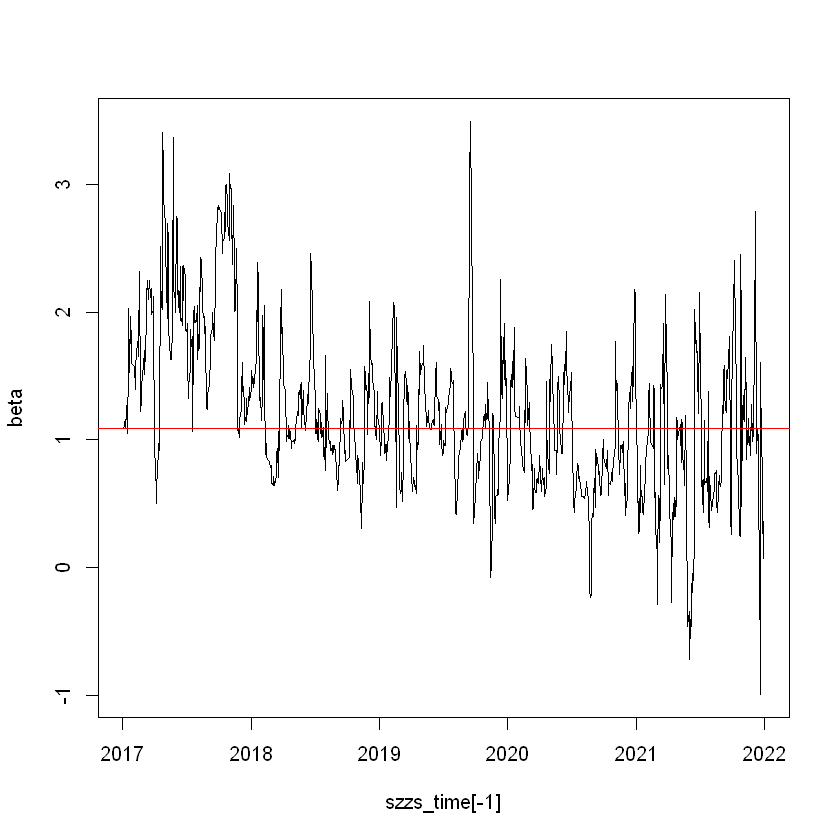

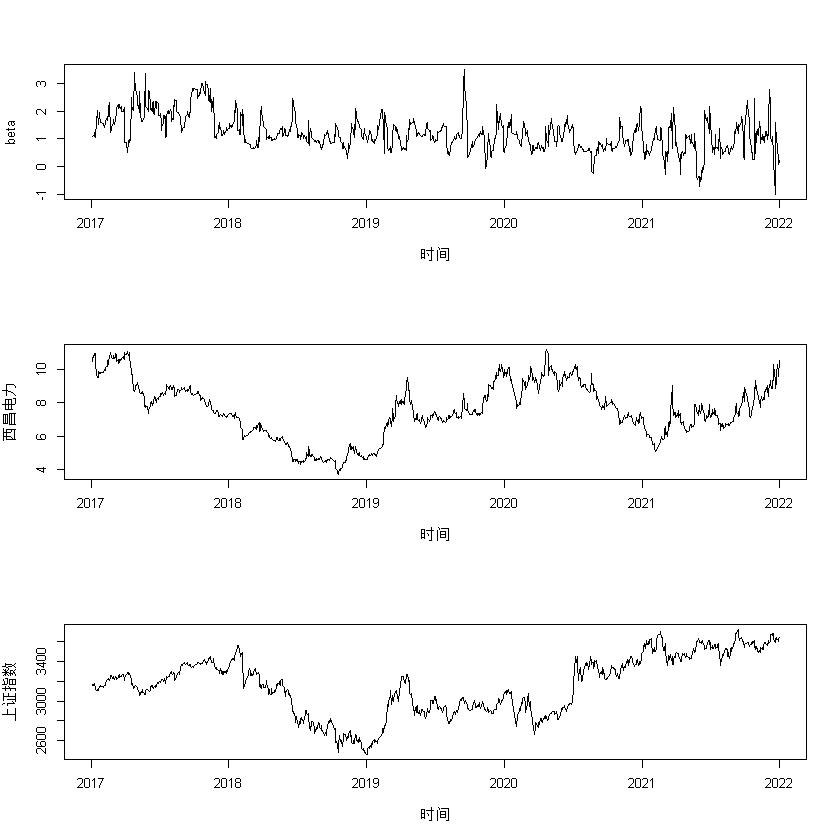

In [196]:
plot(szzs_time[-1],beta,type="l")
abline(h=c(market$coefficients),col='red')
par(mfrow=c(3,1))
plot(time,beta,xlab ="时间", ylab ="beta",type ="l")
plot(time,xcdl_close_price[-1],xlab ="时间", ylab ="西昌电力",type ="l")
plot(time,szzs_price[-1],xlab ="时间", ylab ="上证指数",type ="l")
par(mfrow=c(1,1))

### 出现偏离平均水平的原因

- 最大的偏离出现在2019年9月17日，9月17日其beta产生巨大波动可能是因为其在前两天的交易中收获两根大阳线，股价迅速攀升，而在9月17日股价迅速跌落，使得其对市场价格变动极为敏感
- 西昌电力beta值出现偏离的时间其价格走势与市场走势没有相同的趋势，因为西昌电力的市值小，仅为30亿元左右，其价格易于被资金操纵

## 比较基于纯时间序列模型 ARIMA 和 GARCH 模型对所选取股票收益率样本外预测的精度

#### 选择garch（1，1），有偏t分布进行预测

In [197]:
source("backtest.R")
source("backtestGarch.R")
m1<-auto.arima(xcdl_logreturn)
m1f=backtest(m1,xcdl_logreturn,650,1,inc.mean=F)
m2<-backtestGarch(xcdl_logreturn,650,1,inc.mean=F,cdist = "sstd")

[1] "RMSE of out-of-sample forecasts"
[1] 0.03114354
[1] "Mean absolute error of out-of-sample forecasts"
[1] 0.02226942
[1] "RMSE of out-of-sample forecasts"
[1] 0.03114531
[1] "Mean absolute error of out-of-sample forecasts"
[1] 0.02228452


#### 可以看到，纯时间序列模型ARIMA的预测精度要略低于GARCH模型